## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №27

#### Провести обучение нейронной сети на наборе данных notMNIST_small

In [2]:
import os
import random
from zipfile import ZipFile

import numpy as np
import pandas as pd

from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report

DATA_FILE = 'notMNIST_small.zip'
DATA_FOLDER = 'notMNIST_small'
RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Cuda version: 2.10.1
Num GPUs Available:  1


Распакуем архив с набором данных в текущий каталог,
если каталог с данными еще не существует.

In [3]:
if not os.path.exists(DATA_FOLDER):
    with ZipFile(DATA_FILE, 'r') as myzip:
        myzip.extractall()

Проверим содержимое распакованного каталога с данными

In [4]:
# Считаем все вложенные каталоги
dirs = os.listdir('./notMNIST_small')
dirs

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

Отобразим произвольные 10 файлов изображений из набора данных 

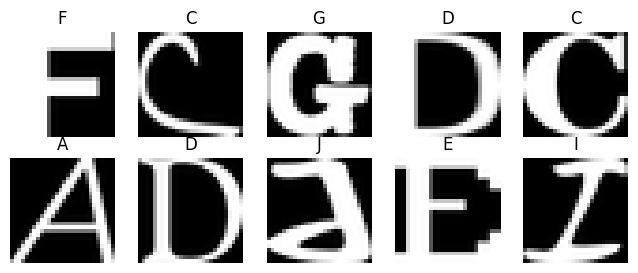

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))

for i in range(2):
    for j in range(5):
        dir = random.choice(dirs)
        file = random.choice(os.listdir(os.path.join(DATA_FOLDER, dir)))
        ax[i, j].imshow(plt.imread(os.path.join(DATA_FOLDER, dir, file)), cmap='gray')
        ax[i, j].set_title(dir)
        ax[i, j].axis('off')

Проверим формат изображений

In [6]:
dir = dirs[0]
file = os.listdir(os.path.join(DATA_FOLDER, dir))[0]
image = Image.open(os.path.join(DATA_FOLDER, dir, file))

print(f'Формат изображения: {image.format} {image.size} {image.mode}')

Формат изображения: PNG (28, 28) L


Выполним загрузку набора данных из файлов

In [7]:
X = []
labels = []

for dir in dirs:
    for file in os.listdir(os.path.join(DATA_FOLDER, dir)):
        try:
            img = Image.open(os.path.join(DATA_FOLDER, dir, file))
            X.append(np.asarray(img, dtype=np.float32))
            labels.append(dir)
        except:
            None # Если файл не удается прочитать - пропускаем

X = np.asarray(X)
labels = np.asarray(labels)

img_size = len(X[0]) # Размер изображения

print(f'Загружен массив изображений\n {X.shape}')

Загружен массив изображений
 (18724, 28, 28)


In [8]:
# Конвертируем целевые метки классов в разряженный массив (One-hot)
num_classes = len(dirs)
y = to_categorical(list(map(lambda x: ord(x)-ord('A'), labels)), num_classes=num_classes)

print(f'Разряженный массив целевых меток\n {y.shape}')

Разряженный массив целевых меток
 (18724, 10)


Подготовим обучающий и тестовые наборы данных

In [10]:
# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним нормализацию значений
X = X / 255.0

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Проверим один из элементов получившихся наборов данных

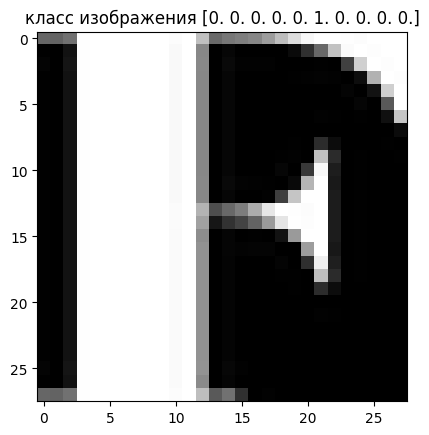

In [53]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f'класс изображения {y_train[0]}');

Проверим распределение изображений по классам

In [11]:
y_classes = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_classes), y=y_classes)
class_weights = dict(enumerate(class_weights))

# Веса классов
class_weights

{0: 0.9966539923954373,
 1: 1.0081538461538462,
 2: 1.0081538461538462,
 3: 1.0231069476971115,
 4: 0.9898791540785499,
 5: 1.0050613496932514,
 6: 0.9636764705882352,
 7: 0.9951404707668945,
 8: 1.0128284389489954,
 9: 0.9996948893974066}

In [171]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, 
                       kernel_initializer='he_normal',
                       #kernel_initializer='lecun_normal',
                       activation='PReLU'), # 'LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU'
    keras.layers.Dense(256, 
                       kernel_initializer='he_normal',
                       activation='PReLU'),
    keras.layers.Dense(128, 
                       kernel_initializer='he_normal',
                       activation='PReLU'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-3,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_model_test',
        monitor = 'val_categorical_accuracy',
        save_Best_only=True,
        verbose=0
    )
]

#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, batch_size=128, epochs=50,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=0)

INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


INFO:tensorflow:Assets written to: keras_model_test\assets


Epoch 24: early stopping


In [136]:
print('Model summary:')
print(model.summary())

print('\nModel history:')
print(history.history.keys())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                         

In [172]:
scores = model.evaluate(X_test, y_test, verbose=0)

print("Accuracy на тестовых данных: %.2f%%" % (scores[1]*100))

Accuracy на тестовых данных: 91.55%


In [173]:
y_pred = model.predict(X_test)
y_pred_arg=np.argmax(y_pred, axis=1)
y_test_arg=np.argmax(y_test, axis=1)

acc = accuracy_score(y_test_arg, y_pred_arg)
print(f'Accuracy:\n{acc}')

#cm = confusion_matrix(y_test_arg, y_pred_arg)
#print(f'Confusion Matrix\n{cm}')

#cr = classification_report(y_test_arg, y_pred_arg)
#print(f'Classification Report:\n{cr}')

176/176 [==============================] - 0s 2ms/step
Accuracy:
0.9154503381986472


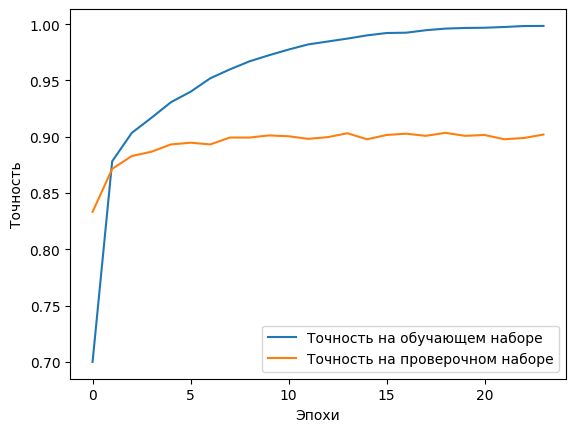

In [174]:
plt.plot(history.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

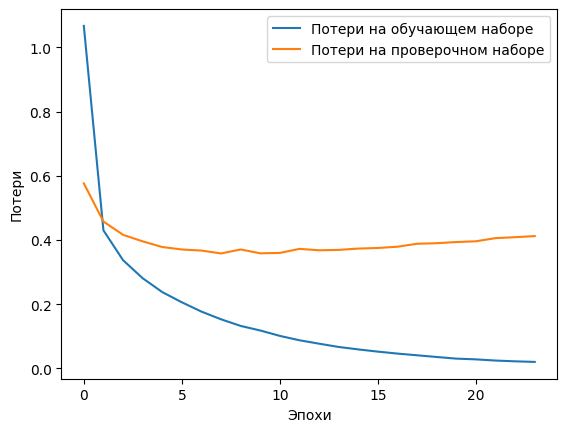

In [175]:
plt.plot(history.history['loss'], label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [41]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                        padding='SAME', activation='relu', input_shape=(28, 28,1)),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model_cnn.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0005), 
              metrics=['categorical_accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-3,
        patience=5,
        verbose=1
    ),
    #tf.keras.callbacks.ModelCheckpoint(
    #    'keras_model_test',
    #    monitor = 'val_categorical_accuracy',
    #    save_Best_only=True,
    #    verbose=0
    #)
]

#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history = model_cnn.fit(X_train, y_train, batch_size=256, epochs=50,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)

Epoch 1/50
41/41 [==============================] - 1s 15ms/step - loss: 0.9129 - categorical_accuracy: 0.7609 - val_loss: 0.4661 - val_categorical_accuracy: 0.8696
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.3878 - categorical_accuracy: 0.8928 - val_loss: 0.3373 - val_categorical_accuracy: 0.9047
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.3070 - categorical_accuracy: 0.9122 - val_loss: 0.2958 - val_categorical_accuracy: 0.9172
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.2623 - categorical_accuracy: 0.9264 - val_loss: 0.2756 - val_categorical_accuracy: 0.9268
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.2275 - categorical_accuracy: 0.9368 - val_loss: 0.2679 - val_categorical_accuracy: 0.9264
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.2055 - categorical_accuracy: 0.9414 - val_loss: 0.2485 - val_categorical_accuracy: 0.9325
Epoch 7/50

In [37]:
print('Model summary:')
print(model_cnn.summary())

print('\nModel history:')
print(history.history.keys())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)

In [42]:
scores = model_cnn.evaluate(X_test, y_test, verbose=0)

print("Accuracy на тестовых данных: %.2f%%" % (scores[1]*100))

Accuracy на тестовых данных: 94.29%


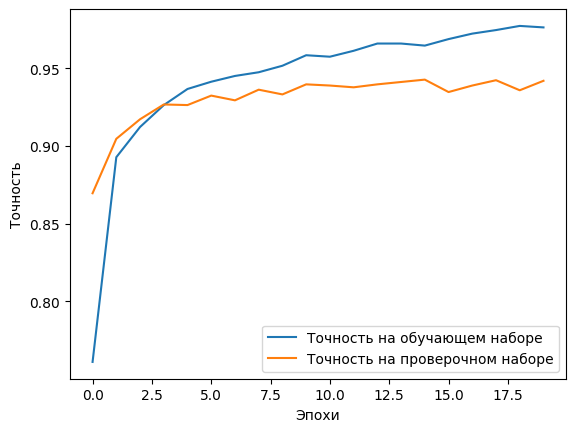

In [43]:
plt.plot(history.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()

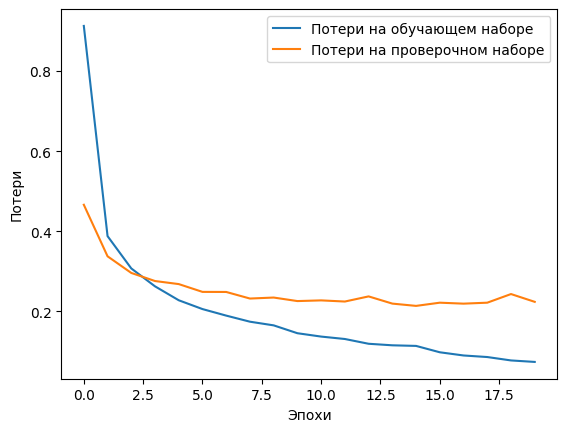

In [44]:
plt.plot(history.history['loss'], label='Потери на обучающем наборе')
plt.plot(history.history['val_loss'], label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()